In [35]:
# Import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics, ensemble
from math import sqrt
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
data = pd.read_csv('generated_dataset.csv')
data.head()

Wellhead Temp. (C)  Wellhead Press (psi)  MMCFD- gas  \
0               53.35               1105.13       12.87   
1               72.25               1026.31        3.42   
2               65.08                722.96        6.23   
3               60.71               1557.23       11.71   
4               46.19               1304.42        8.58   

   BOPD (barrel of oil produced per day)  \
0                                1378.93   
1                                1028.75   
2                                2017.92   
3                                 558.22   
4                                1280.47   

   BWPD (barrel of water produced per day)  BSW - basic solid and water (%)  \
0                                  2812.62                            75.64   
1                                   919.92                            44.21   
2                                  1212.42                            17.55   
3                                  1716.09                            65.79   
4                                  1929.22                            37.45   

   CO2 mol. (%) @ 25 C & 1 Atm.  Gas Grav.  CR-corrosion defect  
0                        3.3628     0.7205               0.2245  
1                        3.8679     0.8940               0.2262  
2                        2.3552     0.7661               0.2305  
3                        1.7253     0.7738               0.2303  
4                        1.8327     0.7611               0.2202

In [3]:
# Check data types
#data.info()

In [4]:
# Descriptive statistics
#data.describe()

In [5]:
# Check for missing values
#data.isnull().sum()

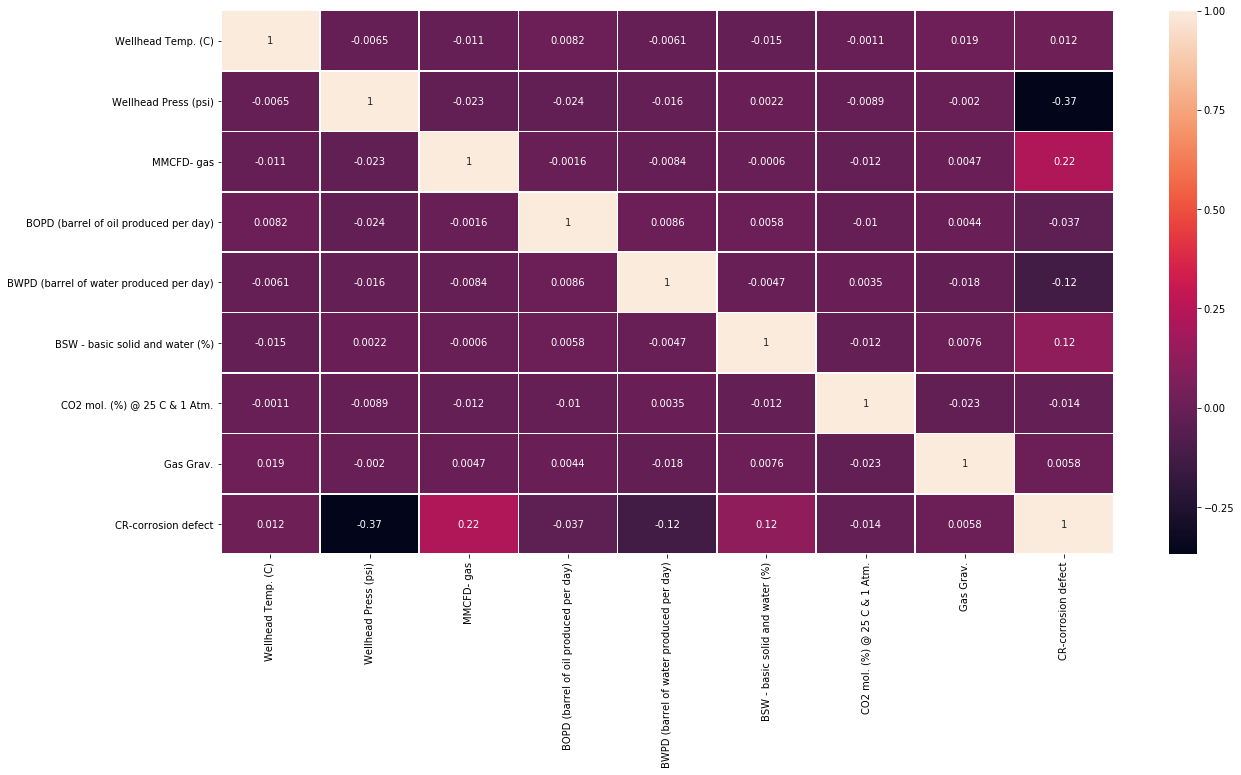

In [6]:
#Checking for correlation between features
fig, ax = plt.subplots(figsize=(20,10))
corr = data[data.columns].corr()
sns.heatmap(corr, annot=True, linewidths=0.5)

Skewness: -0.458970
Kurtosis: 4.577104


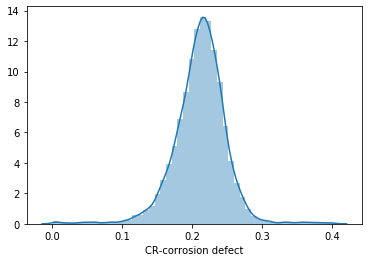

In [7]:
sns.distplot(data['CR-corrosion defect']);
#skewness and kurtosis
print("Skewness: %f" % data['CR-corrosion defect'].skew())
print("Kurtosis: %f" % data['CR-corrosion defect'].kurt())

Skewness: -0.762168
Kurtosis: 5.220999


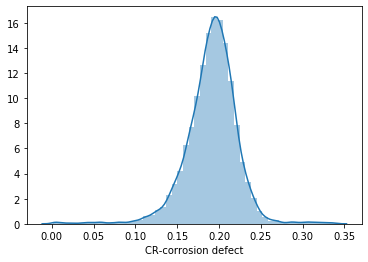

In [8]:
data['CR-corrosion defect'] = np.log1p(data['CR-corrosion defect'])

sns.distplot(data['CR-corrosion defect']);
# skewness and kurtosis
print("Skewness: %f" % data['CR-corrosion defect'].skew())
print("Kurtosis: %f" % data['CR-corrosion defect'].kurt())

## Data Modeling

In [46]:
X = data.iloc[:,1:7]
y = data.iloc[:,8]
X = MinMaxScaler().fit_transform(X)

### PCA

In [47]:
# Initialize instance of PCA transformation
from sklearn.decomposition import PCA
pca = PCA()

# Fit the instance
pca.fit(X)

PCA()

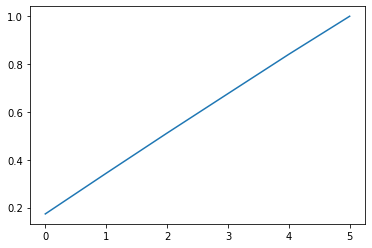

In [48]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [49]:
# How much variance we'd capture with the first 8 components
cumulative_explained_variance[4]

0.840840448578615

In [50]:
# Initialize PCA transformation, only keeping 4 components
pca = PCA(n_components=4)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(X)

# Display shape of PC_items
PC_items.shape

(10292, 4)

In [ ]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = data.index

# Display first 5 rows
items_pca.head()

In [ ]:
# Plot transformed dataset
plt.scatter(items_pca.iloc[:,0], items_pca.iloc[:,1], alpha=0.3, color='g')

# Plot first principal component in black
plt.plot([0, 2], [0, 0], 'k')

# Plot second principal component in red
plt.plot([0, 0], [0, 1], 'r')

# Set axes
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Clear text residue
plt.show()

In [ ]:
# Display explained variance ratio
pca.explained_variance_ratio_

In [55]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(PC_items, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(8233, 4) (2059, 4)


In [56]:
from sklearn.pipeline import make_pipeline

In [57]:
make_pipeline(StandardScaler(), Lasso(random_state=123))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=123))])

In [58]:
# Create pipelines dictionary
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=123))
}

In [59]:
# Add a pipeline for 'rf'
pipelines['rf'] = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123))

# Add a pipeline for 'gb'
pipelines['gb'] = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))

In [60]:
# Check that we have all 5 algorithms, and that they are all pipelines
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


In [61]:
# List tuneable hyperparameters of our Lasso pipeline
pipelines['lasso'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('lasso', Lasso(random_state=123))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'lasso': Lasso(random_state=123),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 123,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [62]:
# Lasso hyperparameters
lasso_hyperparameters = { 
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] 
}

# Ridge hyperparameters
ridge_hyperparameters = { 
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]  
}
# Elastic Net hyperparameters
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}
# Random forest hyperparameters
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}
# Boosted tree hyperparameters
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

In [63]:
# Create hyperparameters dictionary
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters
}

In [64]:
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.


In [65]:
# Create cross-validation object from Lasso pipeline and Lasso hyperparameters
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(pipelines['lasso'], hyperparameters['lasso'], cv=10, n_jobs=-1)

In [66]:
# Fit and tune model
model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=123))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,
                                          5, 10]})

In [67]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [68]:
# Check that we have 5 cross-validation objects
for key, value in fitted_models.items():
    print( key, type(value) )

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [69]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [70]:
from sklearn.exceptions import NotFittedError

for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [71]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

lasso 0.15978854527948133
ridge 0.16351820544228196
enet 0.16346606801379107
rf 0.3031893958279287
gb 0.3055631891275674


### Gradient Boosting Regressor

In [72]:
gbm_model = ensemble.GradientBoostingRegressor(n_estimators=15000, max_depth=4, min_samples_leaf=15, 
                                           min_samples_split=10, learning_rate=0.01, loss='huber', random_state=5)

# Reshape train_target to be a 1d array
#y_train = y_train.as_matrix().flatten()

# Fit model
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=4,
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=15000, random_state=5)

In [73]:
# Make predictions with model
y_pred = gbm_model.predict(X_test)


In [74]:
print("Score:", gbm_model.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Score: 0.25040201647287685
Mean Absolute Error: 0.017517315992702443
Mean Squared Error: 0.0007467622080466398
Root Mean Squared Error: 0.027326950214882007
